# [Deep Q-learning with n-step Rewards](https://web.stanford.edu/class/psych209/Readings/SuttonBartoIPRLBook2ndEd.pdf)

In [1]:
# #uncomment if you're running from colab
# %tensorflow_version 2.x

%load_ext autoreload
%autoreload 2
%matplotlib inline

from collections import deque, Counter
import random
import gym
from datetime import datetime
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras import models, layers, optimizers
from tqdm import tqdm_notebook

In [2]:
from solutions.memories import NStepMemory, VanillaMemory
from solutions.agents import DQNAgent

env = gym.make('CartPole-v1')
mem = NStepMemory(int(1e5), n=2, gamma=0.99)
# mem = VanillaMemory(int(1e5))
a = DQNAgent(state_size = env.reset().shape[0], 
             action_size = env.action_space.n, replay_memory = mem) 

/home/charin/anaconda3/envs/drlnd/lib/python3.6/site-packages/gym/envs/registration.py:14: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)


WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


In [3]:
scores = []
scores_deque = deque(maxlen=100) 
moving_scores = []
start_time = datetime.now()
solved_score=200
action_df = []
weight_df = []

for i in tqdm_notebook(range(10000)):
    if (i+1) % 100==0: print(f'Episdoe {i} Moving Average: {np.mean(scores_deque)}')
    state = env.reset()
    score = 0
    t=0
    actions = []
    while True:
        t+=1
        #select action
        action = a.act(state)  
        actions.append(action)

        #env step
        next_state, reward, done, info = env.step(action)   
        
        #engineer the reward to motivate your agent even more
        if done: 
            fake_reward = reward
        else:
            fake_reward = reward
        
        #agent step
        a.step(state,action,fake_reward,next_state,done)
        
        #collect score
        score += reward
        
        #go to next state
        state = next_state   
        
        #break if done
        if done: break
            
    #book keeping
    scores.append(score)
    scores_deque.append(score)
    moving_scores.append(np.mean(scores_deque))
    action_df.append(Counter(actions))
    weight_df.append([tf.reduce_mean(i).numpy() for i in a.network_local.get_weights()])

    if moving_scores[-1] > solved_score: 
        print(f'Solved at Play {i}: {datetime.now() - start_time} Moving average: {moving_scores[-1]}')
        break

Episdoe 99 Moving Average: 12.02020202020202
Episdoe 199 Moving Average: 9.44
Episdoe 299 Moving Average: 9.55
Episdoe 399 Moving Average: 12.02
Episdoe 499 Moving Average: 50.03
Episdoe 599 Moving Average: 88.24
Episdoe 699 Moving Average: 140.36
Solved at Play 794: 0:11:30.825968 Moving average: 201.41


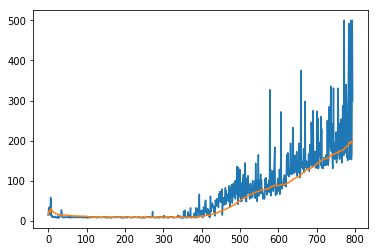

In [4]:
import matplotlib.pyplot as plt
plt.plot(scores)
plt.plot(moving_scores)

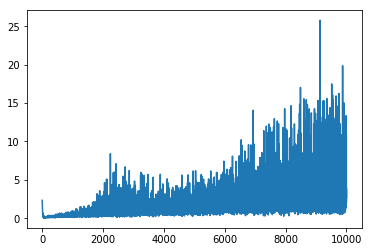

In [5]:
plt.plot(a.losses)

In [6]:
mem.df.head()

,action,done,episode,reward,state,timestep,next_state,discounted_return
0,0,False,0,1.0,"[0.03433668891170977, 0.023492368499176006, 0....",0,"[0.03136551440815641, 0.022621762238504872, 0....",1.5
1,1,False,0,1.0,"[0.034806536281693286, -0.17205109367684368, 0...",1,"[0.0318179496529265, 0.21719508284598038, 0.03...",1.5
2,1,False,0,1.0,"[0.03136551440815641, 0.022621762238504872, 0....",2,"[0.03616185130984611, 0.4117603396147202, 0.03...",1.5
3,1,False,0,1.0,"[0.0318179496529265, 0.21719508284598038, 0.03...",3,"[0.044397058102140514, 0.6064079506149699, 0.0...",1.5
4,1,False,0,1.0,"[0.03616185130984611, 0.4117603396147202, 0.03...",4,"[0.05652521711443991, 0.8012202642094031, 0.00...",1.5


In [12]:
mem.df[mem.df.done==True].head()

,action,done,episode,reward,state,timestep,next_state,discounted_return
14,0,True,0,1.0,"[0.19282835619708308, 1.1986987898028705, -0.1...",14,"[0.19282835619708308, 1.1986987898028705, -0.1...",1.0
46,0,True,1,1.0,"[-0.0038269914973300253, 0.1428512839056358, 0...",32,"[-0.0038269914973300253, 0.1428512839056358, 0...",1.0
69,0,True,2,1.0,"[-0.14378612431004473, -0.44015147823804834, 0...",23,"[-0.14378612431004473, -0.44015147823804834, 0...",1.0
104,1,True,3,1.0,"[-0.18680158831027752, -1.2057293266407787, 0....",35,"[-0.18680158831027752, -1.2057293266407787, 0....",1.0
121,1,True,4,1.0,"[-0.09003737811736337, -1.1655991850855871, 0....",17,"[-0.09003737811736337, -1.1655991850855871, 0....",1.0


In [8]:
mem.df.tail()

,action,done,episode,reward,state,timestep,next_state,discounted_return
51606,0,False,794,1.0,"[1.0683480938007988, -1.2318328296693015, -0.0...",220,"[1.015194805110556, -1.6197431551349593, -0.07...",1.5
51607,0,False,794,1.0,"[1.0437114372074128, -1.425831604842846, -0.07...",221,"[0.9827999420078567, -1.4235965914381228, -0.0...",1.5
51608,1,False,794,1.0,"[1.015194805110556, -1.6197431551349593, -0.07...",222,"[0.9543280101790942, -1.6176053033914313, -0.0...",1.5
51609,0,False,794,1.0,"[0.9827999420078567, -1.4235965914381228, -0.0...",223,"[0.9827999420078567, -1.4235965914381228, -0.0...",1.5
51610,1,False,794,1.0,"[0.9543280101790942, -1.6176053033914313, -0.0...",224,"[0.9543280101790942, -1.6176053033914313, -0.0...",1.0


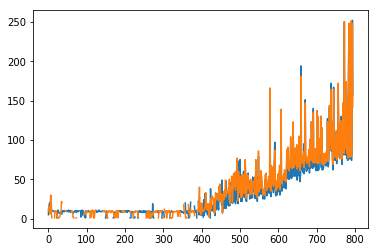

In [9]:
action_df = pd.DataFrame(action_df)
for i in action_df.columns:
    plt.plot(action_df[i])

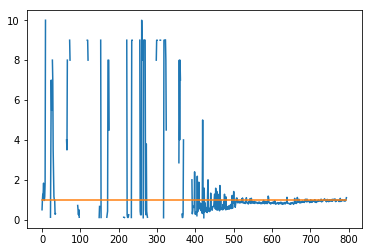

In [10]:
plt.plot(action_df[0]/action_df[1])
plt.plot([1 for i in range(action_df.shape[0])])

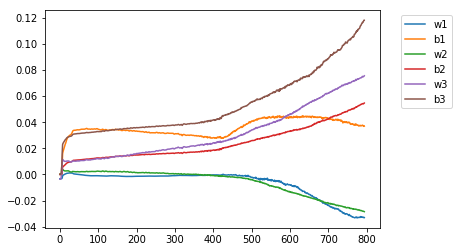

In [11]:
weight_df = pd.DataFrame(weight_df)
weight_df.columns = [str(i.shape) for i in a.network_local.get_weights()]
weight_df.columns = ['w1','b1','w2','b2','w3','b3']
for i in range(weight_df.shape[1]):
    plt.plot(weight_df.iloc[:,i])
plt.legend(bbox_to_anchor=(1.05,1),loc=2)